In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import Callback,TensorBoard
from tensorflow.keras.optimizers import SGD
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
np.random.seed(1213)

In [2]:
class TrainingHistory(Callback):
    def on_train_begin(self,logs={}):
        self.losses = []
        self.valid_losses = []
        self.accs = []
        self.valid_accs = []
        self.epoch = 0

    def on_epoch_end(self,epoch,logs={}):
        self.losses.append(logs.get("loss"))
        self.valid_losses.append(logs.get("val_loss"))
        self.accs.append(logs.get("accs"))
        self.valid_accs.append(logs.get("valid_accs"))
        self.epoch += 1

history = TrainingHistory()

In [3]:
model = Sequential()
model.add(Dense(10,input_shape=(2,)))
model.add(Activation("tanh"))
model.add(Dense(1))
model.add(Activation("tanh"))

model.compile(loss='mean_squared_error', 
                optimizer=SGD(learning_rate=0.1,momentum=0.001,nesterov=True), 
                metrics=['accuracy'])

In [4]:
nb_samples = 200
valid_split = 0.2
test_split = 0.1
samples = np.zeros(nb_samples, dtype=[('input', float, 2),('output', float, 1)])

C:\Users\hajna\AppData\Local\Temp/ipykernel_15104/3446958447.py:4: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  samples = np.zeros(nb_samples, dtype=[('input', float, 2),('output', float, 1)])


In [5]:
for i in range(0,nb_samples,4):
    noise = np.random.normal(0,1,8)
    samples[i] = (-2 + noise[0], -2 + noise[1]), 0
    samples[i + 1] = (2 + noise[2], -2 + noise[3]), 1
    samples[i + 2] = (-2 + noise[4], 2 + noise[5]), 1
    samples[i + 3] = (2 + noise[6], 2 + noise[7]), 0

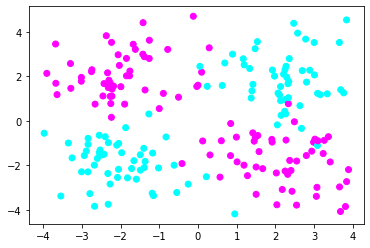

In [6]:
fig1 = plt.figure()
plt.scatter(samples['input'][:,0],samples['input'][:,1],c=samples['output'][:],cmap=plt.cm.cool)

In [7]:
samples_train = samples[0:int(nb_samples*(1-valid_split-test_split))]
samples_valid = samples[int(nb_samples*(1-valid_split-test_split)):int(nb_samples*(1-test_split))]
samples_test  = samples[int(nb_samples*(1-test_split)):]

In [8]:
scaler = preprocessing.StandardScaler().fit(samples_train['input'])
scaler

StandardScaler()

In [9]:
samples_train['input'] = scaler.transform(samples_train['input'])
samples_valid['input'] = scaler.transform(samples_valid['input'])
samples_test['input'] = scaler.transform(samples_test['input'])

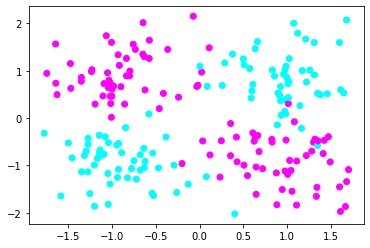

In [10]:
fig1 = plt.figure()
plt.scatter(samples['input'][:,0],samples['input'][:,1],c=samples['output'][:],cmap=plt.cm.cool)

In [11]:
from tensorflow.keras.callbacks import EarlyStopping
patience=10
early_stopping = EarlyStopping(patience=patience,verbose=1)

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(filepath='weights.hdf5',save_best_only=True, verbose=1)

In [13]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8,patience=20,min_lr=10e-5)

In [14]:
from tensorflow.keras.callbacks import LearningRateScheduler
def scheduler(epoch):
    result = 0.1
    if (epoch>20):
        result=0.05
    if (epoch>40):
        result=0.001
    if (epoch>60):
        result=0.0005
    print('learning rate: {}'.format(result))
    return result
        
change_lr = LearningRateScheduler(scheduler)

In [15]:
tensorboard_callback = TensorBoard(log_dir='./logs',write_graph=True,histogram_freq=1)

In [16]:
model.fit(samples_train['input'],samples_train['output'],
          batch_size=20,
          epochs=2500,
          verbose=2,
          validation_data=(samples_valid['input'],samples_valid['output']),
          callbacks=[reduce_lr,checkpoint,early_stopping,history,tensorboard_callback],
          shuffle=True)

Epoch 1/2500
7/7 - 1s - loss: 0.3745 - accuracy: 0.5357 - val_loss: 0.2714 - val_accuracy: 0.3250

Epoch 00001: val_loss improved from inf to 0.27145, saving model to weights.hdf5
Epoch 2/2500
7/7 - 0s - loss: 0.2633 - accuracy: 0.4500 - val_loss: 0.2560 - val_accuracy: 0.3000

Epoch 00002: val_loss improved from 0.27145 to 0.25604, saving model to weights.hdf5
Epoch 3/2500
7/7 - 0s - loss: 0.2563 - accuracy: 0.4929 - val_loss: 0.2425 - val_accuracy: 0.5500

Epoch 00003: val_loss improved from 0.25604 to 0.24251, saving model to weights.hdf5
Epoch 4/2500
7/7 - 0s - loss: 0.2356 - accuracy: 0.4857 - val_loss: 0.2296 - val_accuracy: 0.8250

Epoch 00004: val_loss improved from 0.24251 to 0.22959, saving model to weights.hdf5
Epoch 5/2500
7/7 - 0s - loss: 0.2257 - accuracy: 0.6786 - val_loss: 0.2133 - val_accuracy: 0.6750

Epoch 00005: val_loss improved from 0.22959 to 0.21329, saving model to weights.hdf5
Epoch 6/2500
7/7 - 0s - loss: 0.2123 - accuracy: 0.7786 - val_loss: 0.1990 - val_acc

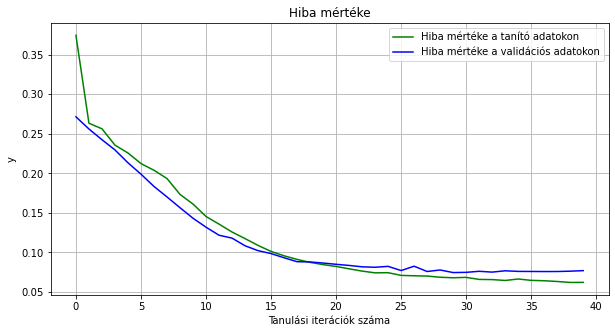

In [17]:
plt.figure(figsize=(10, 5))
plt.title('Hiba mértéke')
plt.plot(np.arange(history.epoch), history.losses, color ='g', label='Hiba mértéke a tanító adatokon') 
plt.plot(np.arange(history.epoch), history.valid_losses, color ='b', label='Hiba mértéke a validációs adatokon')
plt.legend(loc='upper right')
plt.xlabel('Tanulási iterációk száma')
plt.ylabel('y')
plt.grid(True)
plt.show()

Test MSE: 0.102336


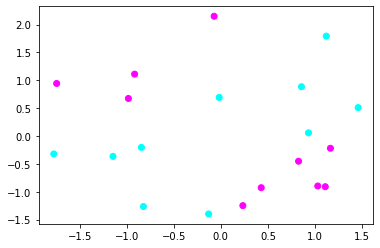

In [18]:
# a legjobb modell visszatöltése
from tensorflow.keras.models import load_model
model = load_model('weights.hdf5')


# teszt adatokkal prediktálás
preds=model.predict(samples_test['input'])
# hiba számítása a teszt adatokon
from sklearn.metrics import mean_squared_error
test_mse = mean_squared_error(samples_test['output'],preds)
print("Test MSE: %f" % (test_mse))
# predikció megjelenítése
fig1=plt.figure()
plt.scatter(samples_test['input'][:,0], \
            samples_test['input'][:,1], \
            c=np.round(preds[:,0]), cmap=plt.cm.cool)